In [1]:
# import packages needed for cleaning

import pandas as pd
import numpy as np
import re

from datetime import date

In [2]:
# read in the csv to a pandas dataframe
df = pd.read_csv("/mnt/c/Users/jpalumbo/DS_Bootcamp/Metis_LinearRegression/Data/Jobs_Merged.csv")

In [3]:
# gain the ability to see all rows/columns if desired
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,Company_Name_Rating,Job_Title,Location,Salary_Estimate,Company_Size,Company_Type,Company_Sector,Year_Founded,Company_Industry,Company_Revenue,Job_Benefits,Job_Qualifications
0,Change Healthcare\n3.3,Lead AI/Machine Learning Engineer,Wyoming,-1,-1,-1,-1,-1,-1,-1,[],"['scikit-learn', 'computer science', 'deep lea..."
1,Change Healthcare\n3.3,Machine Learning Engineer,Wyoming,-1,-1,-1,-1,-1,-1,-1,[],"['computer science', 'deep learning', 'machine..."
2,Change Healthcare\n3.3,Senior Data Analyst,Wyoming,-1,-1,-1,-1,-1,-1,-1,[],"['computer science', 'data mining', 'power bi'..."
3,Change Healthcare\n3.3,Senior Machine Learning Engineer (IV),Wyoming,-1,-1,-1,-1,-1,-1,-1,[],"['computer science', 'deep learning', 'machine..."
4,"Cotiviti, Inc.\n3.4",Sr Data Scientist,United States,-1,-1,-1,-1,-1,-1,-1,['health insurance'],"['scikit-learn', 'computer science', 'natural ..."


In [5]:
df.shape

(12236, 12)

In [6]:
# drop all scraped duplicate job listings (not using location as some jobs are advertised in multiple locations)
## subset uses only the columns listed to identify duplicates
df.drop_duplicates(subset=["Company_Name_Rating", "Job_Title", "Salary_Estimate", "Company_Size", "Company_Type", "Company_Sector", \
                            "Year_Founded", "Company_Industry", "Company_Revenue", "Job_Benefits", "Job_Qualifications"], inplace=True)

# reset the index
df = df.reset_index(drop=True) 

In [7]:
df.shape

(3741, 12)

In [8]:
# Remove all entries without a salary estimate, our target varaibles
df = df[df['Salary_Estimate'] != '-1']

In [9]:
df.shape

(3451, 12)

In [10]:
# clean up the salary column to give us true value of target value

# create an hourly column to jobs that pay hourly
df['Hourly'] = df['Salary_Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
# create an employer provided column for jobs with salary provided from the employer
df['Employer_Provided'] = df['Salary_Estimate'].apply(lambda x: 1 if 'employer provided salary:' in x.lower() else 0)

# clean up text in salary_estimate column
df['Salary_Estimate'] = df['Salary_Estimate'].apply(lambda x: x.split('(')[0])
df['Salary_Estimate'] = df['Salary_Estimate'].apply(lambda x: x.replace("K", '').replace('$', ''))
df['Salary_Estimate'] = df['Salary_Estimate'].apply(lambda x: x.lower().replace('per hour', '').replace('employer provided salary:', ''))

In [11]:
# create a min and max column
df['Min'] = df['Salary_Estimate'].apply(lambda x: int(x.split('-')[0]))
df['Max'] = df['Salary_Estimate'].apply(lambda x: int(x.split('-')[1]) if len(x) > 3 else int(x))

In [12]:
df[['Salary_Estimate', 'Hourly', 'Min', 'Max']].sample(5)

,Salary_Estimate,Hourly,Min,Max
3237,76 - 124,0,76,124
431,64 - 102,0,64,102
1954,56 - 115,0,56,115
1197,85 - 142,0,85,142
2835,100,0,100,100


In [13]:
# create our target variable, which is the projected average salary
# use Glassdoor estimate min and max to create an average of the two or
# use employer provided salary
df['Projected_Salary'] = ((df['Min'] + df['Max']) / 2) * 1000

In [14]:
df[['Salary_Estimate', 'Hourly', 'Min', 'Max', 'Projected_Salary']].sample(5)

,Salary_Estimate,Hourly,Min,Max,Projected_Salary
1999,67 - 112,0,67,112,89500.0
3333,94 - 150,0,94,150,122000.0
2389,95 - 243,0,95,243,169000.0
1925,75 - 161,0,75,161,118000.0
784,84 - 180,0,84,180,132000.0


In [15]:
# use estimated hourly salary or emplyer provided hourly salary to create a yearly salary
# an hourly salary will be estimated at 40 hours a week, 50 weeks a year = (40*50)
df['Projected_Salary'] = np.where(df['Hourly'] == 1, (df['Projected_Salary'] * (40*50))/1000, df['Projected_Salary'])

In [16]:
df[['Salary_Estimate', 'Hourly', 'Min', 'Max', 'Projected_Salary']].sample(5)

,Salary_Estimate,Hourly,Min,Max,Projected_Salary
2953,70 - 80,1,70,80,150000.0
1012,87 - 161,0,87,161,124000.0
2573,63 - 126,0,63,126,94500.0
1856,82 - 143,0,82,143,112500.0
2847,55 - 65,1,55,65,120000.0


In [17]:
# drop columns no longer needed
df.drop(['Salary_Estimate', 'Min', 'Max'], axis=1, inplace=True)

In [18]:
df.sample()

,Company_Name_Rating,Job_Title,Location,Company_Size,Company_Type,Company_Sector,Year_Founded,Company_Industry,Company_Revenue,Job_Benefits,Job_Qualifications,Hourly,Employer_Provided,Projected_Salary
2319,Dezign Concepts LLC,Data Scientist,"Herndon, VA",1 to 50 Employees,Company - Public,Information Technology,2005,IT Services,$1 to $5 million (USD),[],"['computer science', 'machine learning', 'sql'...",0,0,103000.0


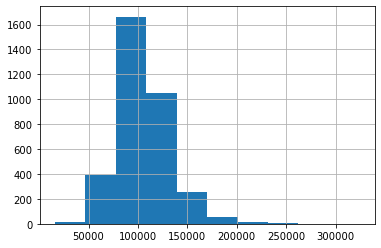

In [19]:
# check to see if the target variable is skewed
df['Projected_Salary'].hist();

In [20]:
# there appears to have a right skew, so create a transformed output of the traget variable to see \
# if more correlated features can be revealed
df['Projected_Salary_Log'] = np.log(df['Projected_Salary'])

In [21]:
# create a ratings column
df['Company_Name'] = df['Company_Name_Rating'].apply(lambda x: x.split('\n')[0])
df['Rating'] = df['Company_Name_Rating'].apply(lambda x: float(x[-3:]) if '\n' in x else -1)

In [22]:
df[['Company_Name_Rating', 'Company_Name', 'Rating']].sample(5)

,Company_Name_Rating,Company_Name,Rating
1543,Guidehouse\n3.7,Guidehouse,3.7
3367,Boys & Girls Clubs of Southeastern Michigan\n3.9,Boys & Girls Clubs of Southeastern Michigan,3.9
611,Northrop Grumman\n4.0,Northrop Grumman,4.0
1972,Franklin Templeton Investments\n3.9,Franklin Templeton Investments,3.9
2989,Apple\n4.3,Apple,4.3


In [23]:
# fill -1 for rating value with column average
rating_mean = df[df['Rating'] != -1].Rating.mean()
df['Rating'] = df['Rating'].apply(lambda x: rating_mean if x == -1 else x)

In [24]:
# drop columns no longer needed
df.drop(['Company_Name_Rating'], axis=1, inplace=True)

In [25]:
df.sample()

,Job_Title,Location,Company_Size,Company_Type,Company_Sector,Year_Founded,Company_Industry,Company_Revenue,Job_Benefits,Job_Qualifications,Hourly,Employer_Provided,Projected_Salary,Projected_Salary_Log,Company_Name,Rating
2040,Senior Product Data Scientist,"Salt Lake City, UT",501 to 1000 Employees,Company - Private,Finance,2012,Venture Capital & Private Equity,Unknown / Non-Applicable,[],"['machine learning', 'pipeline', 'sql', 'pytho...",0,0,123000.0,11.71994,Carta,4.0


In [26]:
states = { "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO",  "Connecticut": "CT", \
        "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", \
        "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", \
        "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", \
        "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", \
        "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", \
        "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", \
        "District of Columbia": "DC", "United States": "USA"}

In [27]:
# extract all state names from Location column and create new State column
df['State'] = df['Location'].apply(lambda x: x[-2:] if ',' in x else -1)
# map states abbreviation to Location in new column where state == -1
df['State'] = np.where(df['State'] == -1, df['Location'].map(states), df['State'])

In [28]:
# create a city column
df['City'] = df['Location'].apply(lambda x: x.split(',')[0] if ',' in x else -1)

In [29]:
# drop column no longer needed
df.drop(['Location'], axis=1, inplace=True)

In [30]:
df.columns

Index(['Job_Title', 'Company_Size', 'Company_Type', 'Company_Sector',
       'Year_Founded', 'Company_Industry', 'Company_Revenue', 'Job_Benefits',
       'Job_Qualifications', 'Hourly', 'Employer_Provided', 'Projected_Salary',
       'Projected_Salary_Log', 'Company_Name', 'Rating', 'State', 'City'],
      dtype='object')

In [31]:
# ensure all elements in these columns are strings (accounting for -1's in columns that may be read as int)
dtype_dict = {'Company_Size':str, 'Company_Type':str, 'Company_Sector':str, 'Year_Founded':str, 'Company_Industry':str, 'Company_Revenue':str, 'Year_Founded':str}

df = df.astype(dtype_dict)

In [32]:
# replace all 'unknown' values in the following columns with -1
column_list = ['Company_Size', 'Company_Type', 'Company_Sector', 'Year_Founded', 'Company_Industry', 'Company_Revenue']
for i in column_list:
    df[i] = df[i].apply(lambda x: '-1' if 'unknown' in x.lower() else x) 

In [33]:
# fix some special case instances for several columns
df['Year_Founded'] = df['Year_Founded'].apply(lambda x: str(-1) if x == 'nan' or x == '1' else x)
df['Year_Founded'] = df['Year_Founded'].apply(lambda x: x.split('.')[0])
df['Company_Size'] = df['Company_Size'].apply(lambda x: str(-1) if x == 'nan' or x == '1' else x)

In [34]:
# create a column for age of company
todays_date = date.today() # get today's date
df['Company_Age'] = df['Year_Founded'].apply(lambda x: int(x) if int(x) < 0 else (todays_date.year - int(x)))

In [35]:
# fill -1 for company_age value with column average
co_age_mean = df[df['Company_Age'] != -1].Company_Age.mean()
df['Company_Age'] = df['Company_Age'].apply(lambda x: co_age_mean if x == -1 else x)

In [36]:
# drop columns no longer needed
df.drop(['Year_Founded'], axis=1, inplace=True)

In [37]:
def get_job(x):
    '''
    Function that evaluates "Job_Title" column and 
    returns general data science role for that job title, 
    also uses regex to isolate terms
    '''
    reg_split = re.split('\s|(?<!\d)[,.]|[,.](?!\d)', x.lower())
    if "natural language processing" in x.lower() \
        or "machine learning" in x.lower() \
        or "artificial intelligence" in x.lower() \
        or "deep learning" in x.lower() \
        or "neural networks" in x.lower() \
        or "ai/ml" in x.lower() \
        or "ai" in reg_split \
        or "ml" in reg_split \
        or "nlp" in reg_split:
        return "ML/AI/NLP"
    elif "data engineer" in x.lower() \
        or "big data" in x.lower() \
        or "data science engineer" in x.lower():
        return "Data Engineer"
    elif "data scientist" in x.lower() \
        or "data science" in x.lower()\
        or "data & applied scientist" in x.lower():
        return "Data Scientist"
    elif "analyst" in x.lower():
        return "Data Analyst"
    elif "statistician" in x.lower() \
        or "statistical" in x.lower():
        return "Statistician"
    else: return "Other"
    
def get_seniority(x):
    '''
    Function that evaluates "Job_Title" column and 
    returns seniority level if present within job title, 
    also uses regex to isolate terms
    '''
    reg_split = re.split('\s|(?<!\d)[,.]|[,.](?!\d)', x.lower())
    if 'senior' in x.lower() \
        or 'sr' in reg_split \
        or 'lead' in x.lower() \
        or 'principal' in x.lower():
        return "Senior"
    elif 'manager' in x.lower() \
        or 'director' in x.lower():
        return 'Manager/Director'
    elif 'junior' in x.lower() \
        or 'jr' in reg_split:
        return "Junior"
    else: return 'N/A'
    
def get_qualifications(x):
    '''
    Function that evaluates "Job_Qualifications" column and 
    returns qualifications into broader groups in order
    to reduce granularity
    '''
    qualifications_list = []
    if 'sql' in x \
        or 'nosql' in x \
        or 'oracle' in x:
        qualifications_list.append('SQL')
    if 'r studio' in x \
        or 'r-studio' in x \
        or 'r' in x:
        qualifications_list.append('R')
    if 'scala' in x:
        qualifications_list.append('Scala')
    if 'python' in x:
        qualifications_list.append('Python')
    if 'natural language processing' in x \
        or 'nlp' in x:
        qualifications_list.append('NLP')
    if 'deep learning' in x \
        or 'machine learning' in x \
        or 'neural networks' in x \
        or 'artificial intelligence' in x \
        or 'ai/ml' in x \
        or 'ml' in x \
        or 'ai' in x:
        qualifications_list.append('AI/ML')
    if 'computer science' in x \
        or 'statistics' in x \
        or 'math' in x \
        or 'mathematics' in x \
        or 'physics' in x \
        or 'engineering' in x \
        or 'engineer' in x \
        or 'algorithm' in x:
        qualifications_list.append('STEM_Background')
    if 'amazon web services' in x \
        or 'google cloud' in x \
        or 'aws' in x:
        qualifications_list.append('Cloud_Computing')
    if 'big data' in x \
        or 'data mining' in x \
        or 'pipeline' in x \
        or 'api' in x:
        qualifications_list.append('Data_Engineering')
    if 'scikit-learn' in x \
        or 'pandas' in x \
        or 'numpy' in x \
        or 'pytorch' in x \
        or 'tensorflow' in x \
        or 'spark' in x:
        qualifications_list.append('Data_Libraries')
    if 'tableau' in x \
        or 'power bi' in x:
        qualifications_list.append('Data_Visualization')
    if 'classification' in x \
        or 'regression' in x:
        qualifications_list.append('Data_Modeling')
    if 'masters' in x:
        qualifications_list.append('Masters')
    if 'phd' in x:
        qualifications_list.append('PhD')
    
    return qualifications_list

In [38]:
# create general data science role column
df['Job_Category'] = df['Job_Title'].apply(get_job)

In [39]:
# create seniority level column
df['Seniority'] = df['Job_Title'].apply(get_seniority)

In [40]:
# create column if the word 'remote' is in job_title or job_benefits
## need to make sure to add axis=1 to compare columns
df['Remote'] = df.apply(lambda x: 1 if 'remote' in x['Job_Title'].lower() or 'remote' in x['Job_Benefits'] else 0, axis=1)  

In [41]:
df[['Job_Title', 'Job_Category', 'Seniority', 'Job_Benefits', 'Remote']].sample(5)

,Job_Title,Job_Category,Seniority,Job_Benefits,Remote
3130,Data Scientist II,Data Scientist,N/A,[],0
3534,Data Science Manager - Decision Analytics,Data Scientist,Manager/Director,[],0
3159,Engineering Statistical Intelligence Analyst,Data Analyst,N/A,[],0
3565,Senior Data Analyst,Data Analyst,Senior,"['health savings account', '401k', 'dental']",0
2421,Data Scientist,Data Scientist,N/A,[],0


In [42]:
# drop columns no longer needed
# also, I decided to drop the job_benefits column because the only benefit I care about is if the job is remote or not
df.drop(['Job_Title', 'Job_Benefits'], axis=1, inplace=True)

In [43]:
df[['Job_Category', 'Seniority', 'Remote']].sample(5)

,Job_Category,Seniority,Remote
2723,ML/AI/NLP,N/A,0
2809,Data Scientist,N/A,0
2113,Data Analyst,N/A,0
3006,Data Scientist,N/A,0
325,ML/AI/NLP,N/A,1


In [44]:
# create general qualifications category
df['Qualifications'] = df['Job_Qualifications'].apply(get_qualifications)

In [45]:
df[['Job_Qualifications', 'Qualifications']].sample(5)

,Job_Qualifications,Qualifications
3325,"['scikit-learn', 'computer science', 'machine ...","[SQL, R, Python, AI/ML, STEM_Background, Data_..."
1711,"['sql', 'python', 'regression', 'masters']","[SQL, R, Python, Data_Modeling, Masters]"
2771,"['deep learning', 'machine learning', 'big dat...","[SQL, R, AI/ML, STEM_Background, Cloud_Computi..."
1620,"['computer science', 'deep learning', 'machine...","[R, Python, AI/ML, STEM_Background, Cloud_Comp..."
545,"['natural language processing', 'deep learning...","[SQL, R, Python, NLP, AI/ML, STEM_Background, ..."


In [46]:
# drop column no longer needed 
df.drop(['Job_Qualifications'], axis=1, inplace=True)

In [47]:
df.sample(1)

,Company_Size,Company_Type,Company_Sector,Company_Industry,Company_Revenue,Hourly,Employer_Provided,Projected_Salary,Projected_Salary_Log,Company_Name,Rating,State,City,Company_Age,Job_Category,Seniority,Remote,Qualifications
724,501 to 1000 Employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,93000.0,11.440355,"Tecolote Research, Inc.",4.1,NM,Albuquerque,48.0,Data Scientist,N/A,0,"[SQL, R, AI/ML, STEM_Background, Data_Visualiz..."


In [48]:
# make company_revenue feature an ordinal feature with 12 being highest revenue and 1 being lowest revenue
df['Company_Revenue'] = df['Company_Revenue'].apply(lambda x: 12 if x == '$10+ billion (USD)' else \
                                                              11 if x == '$5 to $10 billion (USD)' else \
                                                              10 if x == '$2 to $5 billion (USD)' else \
                                                              9 if x == '$1 to $2 billion (USD)' else \
                                                              8 if x == '$500 million to $1 billion (USD)' else \
                                                              7 if x == '$100 to $500 million (USD)' else \
                                                              6 if x == '$50 to $100 million (USD)' else \
                                                              5 if x == '$25 to $50 million (USD)' else \
                                                              4 if x == '$10 to $25 million (USD)' else \
                                                              3 if x == '$5 to $10 million (USD)' else \
                                                              2 if x == '$1 to $5 million (USD)' else \
                                                              1 if x == 'Less than $1 million (USD)' else int(x))

In [49]:
# fill -1 for company_revenue value with column average
co_rev_mean = df[df['Company_Revenue'] != -1].Company_Revenue.mean()
df['Company_Revenue'] = df['Company_Revenue'].apply(lambda x: co_rev_mean if x == -1 else x)

In [50]:
# make company_size feature an ordinal feature with 7 being the most employees and 1 being the least employees
df['Company_Size'] = df['Company_Size'].apply(lambda x: 7 if x == '10000+ Employees' else \
                                                        6 if x == '5001 to 10000 Employees' else \
                                                        5 if x == '1001 to 5000 Employees' else \
                                                        4 if x == '501 to 1000 Employees' else \
                                                        3 if x == '201 to 500 Employees' else \
                                                        2 if x == '51 to 200 Employees' else \
                                                        1 if x == '1 to 50 Employees' else int(x))

In [51]:
# fill -1 for company_size value with column average
co_size_mean = df[df['Company_Size'] != -1].Company_Size.mean()
df['Company_Size'] = df['Company_Size'].apply(lambda x: co_size_mean if x == -1 else x)

In [53]:
# create region column 
# data found here: https://www.nationsonline.org/oneworld/US-states-by-area.htm
region_dict = {"AL": 'E_S_Central', "AK": 'Pacific', "AZ": 'Mountain', "AR": 'W_S_Central', "CA": 'Pacific', "CO": 'Mountain', "CT": 'New England',  \
                "DE": 'South Atlantic', "FL": 'South Atlantic', "GA": 'South Atlantic', "HI": 'Pacific', "ID": 'Mountain', "IL": 'E_N_Central', "IN": 'E_N_Central', \
                "IA": 'W_N_Central', "KS": 'W_N_Central', "KY": 'E_S_Central', "LA": 'W_S_Central', "ME": 'New England', "MD": 'South Atlantic', "MA": 'New England', \
                "MI": 'E_N_Central', "MN": 'W_N_Central', "MS": 'E_S_Central', "MO": 'W_N_Central', "MT": 'Mountain', "NE": 'W_N_Central', "NV": 'Mountain', \
                "NH": 'New England', "NJ": 'Middle Atlantic', "NM": 'Mountain', "NY": 'Middle Atlantic', "NC": 'South Atlantic', "ND": 'W_N_Central', "OH": 'E_N_Central', \
                "OK": 'W_S_Central', "OR": 'Pacific', "PA": 'Middle Atlantic', "RI": 'New England', "SC": 'South Atlantic', "SD": 'W_N_Central', "TN": 'E_S_Central', \
                "TX": 'W_S_Central', "UT": 'Mountain', "VT": 'New England', "VA": 'South Atlantic', "WA": 'Pacific', "WV": 'South Atlantic', "WI": 'E_N_Central', \
                "WY": 'Mountain', "DC": 'South Atlantic', "USA": 'United States'}

In [54]:
# map each state's region to a new region column
df['Region'] = df['State'].map(region_dict)

In [57]:
# rearrange columns
df = df[['Job_Category', 'Seniority', 'Company_Name', 'Rating', 'City', 'State', 'Region', 'Company_Age', 'Company_Size', 'Company_Type', 'Company_Sector', 'Company_Industry', 'Company_Revenue', 'Hourly', 'Employer_Provided', 'Remote', 'Qualifications', 'Projected_Salary_Log', 'Projected_Salary']] 

In [58]:
df.sample(5)

,Job_Category,Seniority,Company_Name,Rating,City,State,Region,Company_Age,Company_Size,Company_Type,Company_Sector,Company_Industry,Company_Revenue,Hourly,Employer_Provided,Remote,Qualifications,Projected_Salary_Log,Projected_Salary
2966,Data Analyst,Senior,Cox Automotive,4.100000,Draper,UT,Mountain,7.000000,7.000000,Company - Private,Information Technology,IT Services,9.046371,0,0,0,"[SQL, R, Cloud_Computing, Data_Engineering]",11.451050,94000.0
3686,Data Scientist,N/A,FedEx Services,4.200000,-1,TN,E_S_Central,21.000000,7.000000,Company - Public,Transportation & Logistics,Logistics & Supply Chain,2.000000,0,1,1,"[R, Scala, Python, AI/ML, STEM_Background, Dat...",11.775290,130000.0
2517,Other,Junior,IBM,3.900000,Baton Rouge,LA,W_S_Central,110.000000,7.000000,Company - Public,Information Technology,IT Services,12.000000,0,0,0,"[SQL, R, AI/ML]",11.082143,65000.0
573,Data Scientist,N/A,Deloitte,4.000000,Gilbert,AZ,Mountain,171.000000,7.000000,Company - Private,Accounting & Legal,Accounting,12.000000,0,0,0,"[R, Python, STEM_Background, Data_Modeling, PhD]",11.461632,95000.0
258,ML/AI/NLP,N/A,Resiliency LLC,3.965068,Seattle,WA,Pacific,56.151689,4.883358,Company - Private,-1,-1,9.046371,0,0,0,"[R, AI/ML, STEM_Background, Cloud_Computing, M...",11.643954,114000.0


In [59]:
# get dummy variables for qualifications column
df_dummy = df['Qualifications'].str.join('|').str.get_dummies()

In [60]:
# merge dummy_df with original df
df = df.merge(df_dummy, left_index=True, right_index=True).reset_index(drop=True)

In [61]:
# drop column no longer needed 
df.drop(['Qualifications'], axis=1, inplace=True)

In [62]:
df.sample(5)

,Job_Category,Seniority,Company_Name,Rating,City,State,Region,Company_Age,Company_Size,Company_Type,Company_Sector,Company_Industry,Company_Revenue,Hourly,Employer_Provided,Remote,Projected_Salary_Log,Projected_Salary,AI/ML,Cloud_Computing,Data_Engineering,Data_Libraries,Data_Modeling,Data_Visualization,Masters,NLP,PhD,Python,R,SQL,STEM_Background,Scala
62,Data Scientist,N/A,aThingz Inc.,3.965068,Southfield,MI,E_N_Central,56.151689,1.0,Company - Private,-1,-1,9.046371,0,1,0,11.512925,100000.0,1,0,1,1,1,0,0,1,1,1,1,0,1,0
2296,Data Scientist,N/A,"Salient CRGT, Inc",3.600000,Hanover,MD,South Atlantic,56.151689,5.0,Company - Private,Information Technology,Enterprise Software & Network Solutions,7.000000,0,0,0,11.492723,98000.0,0,0,1,0,0,0,1,0,0,1,1,1,1,0
1789,Data Scientist,Senior,Robinhood,4.400000,New York,NY,Middle Atlantic,8.000000,5.0,Company - Public,Finance,Brokerage Services,9.046371,0,0,0,11.801857,133500.0,0,0,0,0,0,0,0,0,0,1,1,1,1,0
894,ML/AI/NLP,Senior,Recruiting From Scratch,4.900000,West Lafayette,IN,E_N_Central,2.000000,1.0,Company - Private,Business Services,Staffing & Outsourcing,2.000000,0,0,0,11.424094,91500.0,1,0,0,1,1,0,0,1,0,1,1,0,1,0
747,Other,Manager/Director,KPMG,3.900000,Kansas City,KS,W_N_Central,34.000000,7.0,Company - Private,Business Services,Consulting,9.000000,0,0,0,11.630709,112500.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [63]:
df.columns

Index(['Job_Category', 'Seniority', 'Company_Name', 'Rating', 'City', 'State',
       'Region', 'Company_Age', 'Company_Size', 'Company_Type',
       'Company_Sector', 'Company_Industry', 'Company_Revenue', 'Hourly',
       'Employer_Provided', 'Remote', 'Projected_Salary_Log',
       'Projected_Salary', 'AI/ML', 'Cloud_Computing', 'Data_Engineering',
       'Data_Libraries', 'Data_Modeling', 'Data_Visualization', 'Masters',
       'NLP', 'PhD', 'Python', 'R', 'SQL', 'STEM_Background', 'Scala'],
      dtype='object')

In [64]:
# rearrange columns one last time
df = df[['Job_Category', 'Seniority', 'Company_Name', 'Rating', 'City', 'State', 'Region', 'Company_Age', 'Company_Size', 'Company_Type', 'Company_Sector', 'Company_Industry', 'Company_Revenue', 'Hourly', 'Employer_Provided', 'Remote', 'AI/ML', 'Cloud_Computing', 'Data_Engineering', 'Data_Libraries', 'Data_Modeling', 'Data_Visualization', 'Masters', 'NLP', 'PhD', 'Python', 'R', 'SQL', 'STEM_Background', 'Scala', 'Projected_Salary_Log', 'Projected_Salary']]

In [65]:
df.sample(5)

,Job_Category,Seniority,Company_Name,Rating,City,State,Region,Company_Age,Company_Size,Company_Type,Company_Sector,Company_Industry,Company_Revenue,Hourly,Employer_Provided,Remote,AI/ML,Cloud_Computing,Data_Engineering,Data_Libraries,Data_Modeling,Data_Visualization,Masters,NLP,PhD,Python,R,SQL,STEM_Background,Scala,Projected_Salary_Log,Projected_Salary
1907,Other,Senior,Providence,3.7,-1,AK,Pacific,25.0,7.0,Government,Government,State & Regional Agencies,9.046371,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,11.661345,116000.0
851,ML/AI/NLP,Senior,Recruiting From Scratch,4.9,Albuquerque,NM,Mountain,2.0,1.0,Company - Private,Business Services,Staffing & Outsourcing,2.000000,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,0,11.487608,97500.0
2539,ML/AI/NLP,Senior,"TuSimple, Inc.",4.5,San Jose,CA,Pacific,6.0,3.0,Company - Public,Information Technology,Computer Hardware & Software,9.046371,0,0,0,1,0,1,1,0,0,1,0,1,1,1,0,1,0,11.915052,149500.0
2263,Data Engineer,N/A,IBM,3.9,Baton Rouge,LA,W_S_Central,110.0,7.0,Company - Public,Information Technology,IT Services,12.000000,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,11.332602,83500.0
1559,Data Engineer,N/A,"JPMorgan Chase Bank, N.A.",3.7,Wilmington,DE,South Atlantic,222.0,7.0,Subsidiary or Business Segment,Finance,Banks & Credit Unions,12.000000,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,11.356272,85500.0


In [66]:
df.shape

(3451, 32)

In [67]:
df.dtypes

Job_Category             object
Seniority                object
Company_Name             object
Rating                  float64
City                     object
State                    object
Region                   object
Company_Age             float64
Company_Size            float64
Company_Type             object
Company_Sector           object
Company_Industry         object
Company_Revenue         float64
Hourly                    int64
Employer_Provided         int64
Remote                    int64
AI/ML                     int64
Cloud_Computing           int64
Data_Engineering          int64
Data_Libraries            int64
Data_Modeling             int64
Data_Visualization        int64
Masters                   int64
NLP                       int64
PhD                       int64
Python                    int64
R                         int64
SQL                       int64
STEM_Background           int64
Scala                     int64
Projected_Salary_Log    float64
Projecte

In [68]:
# export the dataframe to a csv 
df.to_csv('Data/Cleaned_Jobs_Data.csv', index=False)